In [1]:
import numpy as np
from qiskit import QuantumCircuit, IBMQ, transpile
import qiskit.compiler.transpiler as transpiler
from qiskit.transpiler.passes import DynamicalDecoupling
from qiskit.circuit.library import XGate
from qiskit.tools.monitor import job_monitor

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibmq_manila')

In [3]:
backend.defaults().instruction_schedule_map.get('x', [0])

Schedule((0, Play(Drag(duration=160, amp=(0.19659515188383553+0j), sigma=40, beta=-0.5418161972707253, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")

In [4]:
from qiskit.transpiler.preset_passmanagers import level_0_pass_manager, level_1_pass_manager, level_2_pass_manager, level_3_pass_manager
preset_pms = [level_0_pass_manager, level_1_pass_manager, level_2_pass_manager, level_3_pass_manager]

def transpile_with_dynamical_decoupling(circuit, backend, initial_layout, num_xx=1, optimization_level=1):
    if num_xx == 0:
        return transpile(circuit, backend=backend, initial_layout=initial_layout, optimization_level=optimization_level)
    
    circuits = [circuit]
    
    transpile_args = transpiler._parse_transpile_args(
        circuits, # circuits,
        backend, # backend,
        None, # basis_gates,
        None, # coupling_map,
        None, # backend_properties,
        initial_layout, # initial_layout,
        None, # layout_method,
        None, # routing_method,
        None, # translation_method,
        'alap', # scheduling_method,
        None, # instruction_durations,
        None, # dt,
        None, # approximation_degree,
        None, # seed_transpiler,
        optimization_level, # optimization_level,
        None, # callback,
        None, # output_name,
        None  # timing_constraints,
    )

    transpiler._check_circuits_coupling_map(circuits, transpile_args, backend)

    pass_manager_config = transpile_args[0]["pass_manager_config"]

    # we choose an appropriate one based on desired optimization level
    level = transpile_args[0]["optimization_level"]

    pass_manager = preset_pms[level](pass_manager_config)
    
    default_passes = pass_manager.passes()
    scheduling = default_passes[-2]['passes']
    dd_sequence = [XGate(), XGate()] * num_xx
    dd = DynamicalDecoupling(pass_manager_config.instruction_durations, dd_sequence=dd_sequence)
    scheduling.append(dd)
    pass_manager.replace(-2, scheduling)

    return pass_manager.run(
        circuit, callback=transpile_args[0]["callback"], output_name=transpile_args[0]["output_name"]
    )

In [5]:
N = 5
inst_map = backend.defaults().instruction_schedule_map
sx_duration = inst_map.get('sx', [0]).instructions[0][1].duration
x_duration = inst_map.get('x', [0]).instructions[0][1].duration

interval = 1024
full_interval = 2 * (interval * N + x_duration * N)

circuits = []

for num_xx in range(N + 1):
    circuit = QuantumCircuit(1, 1)
    circuit.sx(0)
    circuit.delay(full_interval)
    circuit.sx(0)
    circuit.measure(0, 0)
    circuit = transpile_with_dynamical_decoupling(circuit, backend, [0], num_xx=num_xx)

    circuits.append(circuit)

In [6]:
circuits[0].draw(idle_wires=False)

┌────┐┌──────────────────┐┌────┐┌─┐
q_0 -> 0 ┤ √X ├┤ Delay(11840[dt]) ├┤ √X ├┤M├
         └────┘└──────────────────┘└────┘└╥┘
    c: 1/═════════════════════════════════╩═
                                          0

In [7]:
circuits[1].draw(idle_wires=False)

┌────┐┌─────────────────┐┌───┐┌─────────────────┐┌───┐»
q_0 -> 0 ┤ √X ├┤ Delay(2880[dt]) ├┤ X ├┤ Delay(5760[dt]) ├┤ X ├»
         └────┘└─────────────────┘└───┘└─────────────────┘└───┘»
    c: 1/══════════════════════════════════════════════════════»
                                                               »
«         ┌─────────────────┐┌────┐┌─┐
«q_0 -> 0 ┤ Delay(2880[dt]) ├┤ √X ├┤M├
«         └─────────────────┘└────┘└╥┘
«    c: 1/══════════════════════════╩═
«                                   0

In [8]:
circuits[2].draw(idle_wires=False)

┌────┐┌─────────────────┐┌───┐┌─────────────────┐┌───┐»
q_0 -> 0 ┤ √X ├┤ Delay(1400[dt]) ├┤ X ├┤ Delay(2800[dt]) ├┤ X ├»
         └────┘└─────────────────┘└───┘└─────────────────┘└───┘»
    c: 1/══════════════════════════════════════════════════════»
                                                               »
«         ┌─────────────────┐┌───┐┌─────────────────┐┌───┐┌─────────────────┐»
«q_0 -> 0 ┤ Delay(2800[dt]) ├┤ X ├┤ Delay(2800[dt]) ├┤ X ├┤ Delay(1400[dt]) ├»
«         └─────────────────┘└───┘└─────────────────┘└───┘└─────────────────┘»
«    c: 1/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«         ┌────┐┌─┐
«q_0 -> 0 ┤ √X ├┤M├
«         └────┘└╥┘
«    c: 1/═══════╩═
«                0

In [9]:
circuits[5].draw(idle_wires=False)

┌────┐┌────────────────┐┌───┐┌─────────────────┐┌───┐»
q_0 -> 0 ┤ √X ├┤ Delay(512[dt]) ├┤ X ├┤ Delay(1024[dt]) ├┤ X ├»
         └────┘└────────────────┘└───┘└─────────────────┘└───┘»
    c: 1/═════════════════════════════════════════════════════»
                                                              »
«         ┌─────────────────┐┌───┐┌─────────────────┐┌───┐┌─────────────────┐»
«q_0 -> 0 ┤ Delay(1024[dt]) ├┤ X ├┤ Delay(1024[dt]) ├┤ X ├┤ Delay(1024[dt]) ├»
«         └─────────────────┘└───┘└─────────────────┘└───┘└─────────────────┘»
«    c: 1/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«         ┌───┐┌─────────────────┐┌───┐┌─────────────────┐┌───┐»
«q_0 -> 0 ┤ X ├┤ Delay(1024[dt]) ├┤ X ├┤ Delay(1024[dt]) ├┤ X ├»
«         └───┘└─────────────────┘└───┘└─────────────────┘└───┘»
«    c: 1/═════════════════════════════════════════════════════»
«                                                              »
«         ┌─────────────────┐┌───┐┌─────────────────┐┌───┐┌─────────────────┐»
«q_0 -> 0 ┤ Delay(1024[dt]) ├┤ X ├┤ Delay(1024[dt]) ├┤ X ├┤ Delay(1024[dt]) ├»
«         └─────────────────┘└───┘└─────────────────┘└───┘└─────────────────┘»
«    c: 1/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«         ┌───┐┌────────────────┐┌────┐┌─┐
«q_0 -> 0 ┤ X ├┤ Delay(512[dt]) ├┤ √X ├┤M├
«         └───┘└────────────────┘└────┘└╥┘
«    c: 1/══════════════════════════════╩═
«                                       0

In [10]:
job = backend.run(circuits, shots=8192)
print(job.job_id())
job_monitor(job)

616d281e2f4fbab80d1bac26
Job Status: job has successfully run


In [11]:
from qiskit.visualization import plot_histogram

In [12]:
result = job.result()

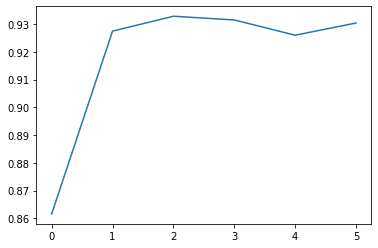

In [15]:
import matplotlib.pyplot as plt

y_values = [(result.get_counts(ic).get('1') / 8192.) for ic in range(N + 1)]
plt.plot(y_values)